### EMTOOLS -- Postprocessing
This notebook processes semantic segmentations from Uni-EM into instance segmentations. It outputs the measurements defined below as a pandas dataframe, excel spreadsheet, csv, and in various figures.

**Author:** Philip Ruthig, Paul Flechsig Institute, Center of Neuropathology and Brain Research Leipzig

**Contact:** philip.ruthig@medizin.uni-leipzig.de // philip.ruthig@gmail.com

**Publication:**
Please contact me if you want to use this code for any publication.

#### These measures are output for every fiber (inner) and myelin (outer) instance in a paired manner:
- `label`: unique ID for every cell found.
- `area`: area (in pixels) of the given cell in µm²
- `centroid-0` and `centroid-1`: x and y coordinats of the centroid of each cell
- `axis_major_length`: equivalent ellipse major axis length (diameter) in µm
- `axis_minor_length`: equivalent ellipse minor axis length (diameter) in µm
- `eccentricity`: Value between 0 and 1 that defines the non-circularity of a structure. The closer it is to 0, the closer it is to a circle. An eccentricity of 1 means it is a parabola. Eccentricity here is defined as the ratio of the focal distance (distance between focal points) over the major axis length of the ellipse with the same second moment as the binary structure.
- `orientation`: Orientation of the structure in rad, value between -1/2pi and +1/2pi
- `equivalent_diameter_area`: diameter of the circle with an equivalent area to the cell
- `slice`: a slice object to extract this cell from the image

For more detailed info on the extracted values, see the original documentation of scikit-image function used to extract these values:
- https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

#### These measures are output for each pair of fiber and myelin:
- `file`: The filename of the image this cell came from
- `gratio`: approximate g ratio of the given cell, here defined as axis_minor_length(fiber)/axis_minor_length/(myelin)
- `orientation_mean_deg`: Mean orientation between the fiber and myelin (in degrees)
- `eccentricity_mean`: Mean eccentricity between the fiber and myelin

In [1]:
import numpy as np
import tifffile as tf
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import pandas as pd
import math as m
import skimage
import tqdm
import os
import colorcet as cc
import plotly.io as pio
import plotly.express as px
import re
import pickle
import cv2
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import disk
from os import listdir
from os.path import isfile, join
%matplotlib inline

c:\Users\Hoellenmaschine2\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def resolve_undersegmentation(outer_labels,inner_labels):
    '''
    This function resolves undersegmented 'kissing' cells. This function assumes that inner_labels never touch, but outer_labels do.
    Each outer area of a cell must touch the corresponding inner area.

    outer_labels = outer labels with undersegmented kissing cells that need to be seperated
    inner_labels = inner labels without undersegmented kissing cells

    returns: Two arrays of the same shape, with uniform labels across both images. 
    '''
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    outer_labels = outer_labels.astype('bool')
    inner_labels = inner_labels.astype('bool')
    # do distance transformation of combined binary image of outer+inner
    seg_dist = ndi.distance_transform_edt(outer_labels+inner_labels)
    # Generate the markers as local maxima of the distance to the background
    coords = peak_local_max(seg_dist, footprint=np.ones((3, 3)), labels=ndi.label(inner_labels)[0], num_peaks_per_label=1)
    # initializie empty mask 
    mask = np.zeros(seg_dist.shape, dtype=bool)
    # insert maximum points into the empty array
    mask[tuple(coords.T)] = True
    # label each maximum
    markers, n = ndi.label(mask)
    # print("number of cells: " + str(n))
    # perform watershed on outer_labels and inner_labels combined
    outer_cells = watershed(-seg_dist, markers, mask=(outer_labels+inner_labels))
    inner_cells = np.copy(outer_cells)
    # sort the cells (which are now labeled with the same label inner and outer) back into inner and outer labels
    inner_cells[inner_labels==0] = 0
    outer_cells[inner_labels==True] = 0
    return outer_cells,inner_cells

def keep_largest_structure(boolean_array):
    from scipy import ndimage
    # Label each connected component in the boolean array
    labeled_array, num_features = ndimage.label(boolean_array)

    # Calculate the size of each labeled component
    component_sizes = np.bincount(labeled_array.ravel())

    # Find the index of the largest component
    largest_component_index = np.argmax(component_sizes[1:]) + 1

    # Create a boolean mask to keep only the largest component
    largest_component_mask = labeled_array == largest_component_index

    # Apply the mask to the boolean array
    boolean_array[largest_component_mask] = True
    boolean_array[~largest_component_mask] = False

    return boolean_array

def find_numbers(string):
    """
    Finds up to 4-digit numbers in a string.
    Parameters:
        string
    
        Returns:
        list of numbers
    """
    pattern = r'\d{1,4}'  # Regular expression pattern for matching numbers with 1 to 4 digits
    numbers = re.findall(pattern, string)
    numbers = [int(num) for num in numbers]  # Convert numbers to integers
    return numbers

def z_score_dataframe(dataframe):
    """
    Z-scores a Pandas DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The z-scored DataFrame.
    """
    z_scored_dataframe = (dataframe - dataframe.mean()) / dataframe.std(ddof=0)
    return z_scored_dataframe

def remove_whitespaces(string):
    return "".join(string.split())

def reconstruct_images(subimg_name_list,img_coord_list,img_original_shape_list,img_original_name_list,save_dir,overlap):
    i=0
    for orig_img_name in np.unique(np.array(img_original_name_list)):
        rec_img = np.zeros(img_original_shape_list[i], dtype='uint8')
        print(f"resaving image: {orig_img_name}")

        
        for img_coords in tqdm.tqdm(img_coord_list):
            temp_subimg = cv2.imread(f"2_predicted\\{orig_img_name}{remove_whitespaces(str(img_coords))}.png")
            # temp_subimg = cv2.imread(f"1_preprocessed\\{orig_img_name}{remove_whitespaces(str(img_coords))}.png")
            # print(f"opening {orig_img_name}+{remove_whitespaces(str(img_coords))}.png")

            y_start, y_end, x_start, x_end = img_coords

            # Ensure the coordinates are within the bounds of rec_img
            y_end = min(y_end, rec_img.shape[0])
            x_end = min(x_end, rec_img.shape[1])

            # Determine the dimensions for insertion
            try:
                img_height, img_width = temp_subimg.shape[:2]
            except:
                # print("continuing: " + str(img_coords))
                continue

            y_height = min(y_end - y_start, img_height)
            x_width = min(x_end - x_start, img_width)

            if y_height > 0 and x_width > 0:
                rec_img[y_start+overlap//2:y_start + y_height-overlap//2, x_start+overlap//2:x_start + x_width-overlap//2] = temp_subimg[overlap//2:y_height-overlap//2, overlap//2:x_width-overlap//2, 0]
            # break
        ## crop to region without border artifacts
        rec_img = rec_img[overlap//2:-overlap//2,overlap//2:-overlap//2]
        tf.imwrite(save_dir+orig_img_name+".tif",rec_img.astype('uint8'))
        print('writing fused image to:' + str(save_dir+orig_img_name+".tif"))
        i+=1
        # break

def mk_dir(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# define qualitative colormap
glasbey = cc.cm.glasbey_dark_r
glasbey.set_under(color="black")

In [3]:
# path to semantic segmentation images
path_raw_predictions = (r"2_predicted\\")
path_reconstructed_predictions = (r"2_predicted_reconstructed\\")
path_results = (r"3_postprocessed\\")

In [4]:
### USER INPUTS
troubleshoot_small_big_gratios = False # Set to True for troubleshooting purposes. Only set to True if you get weird (lots of very small (<0.1) and/or big (>0.9)) gratios
plot_all = False # if False, only final plots that are saved. Use True for troubleshooting purposes only.
px_size = 4.3*4 # pixel size in nm, multiplied by the downscaling factor applied in the preprocessing step
threshold_myelin = 50
threshold_fiber_upper = 40 
threshold_fiber_lower = 28
overlap = 200 # overlap defined in step 1

In [5]:
### reconstruct images from small image slices and re-save them.
# load metadata from pkl files
with open(r"img_name_list","rb") as fp:
    img_name_list = pickle.load(fp)

with open(r"img_coord_list","rb") as fp:
    img_coord_list = pickle.load(fp)

with open(r"img_original_shape_list","rb") as fp:
    img_original_shape_list = pickle.load(fp)

with open(r"img_original_name_list","rb") as fp:
    img_original_name_list = pickle.load(fp)

reconstruct_images(img_name_list,img_coord_list,img_original_shape_list,img_original_name_list,save_dir=r"2_predicted_reconstructed\\",overlap=overlap)

resaving image: Sample_Data_SWM.ome


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 87.33it/s]

writing fused image to:2_predicted_reconstructed\\Sample_Data_SWM.ome.tif


In [6]:
prediction_files = [f for f in listdir(path_reconstructed_predictions) if isfile(join(path_reconstructed_predictions, f)) and f != ".gitkeep"]

In [7]:
i = 0 # index, number of pictures already run
prediction_files = [f for f in listdir(path_reconstructed_predictions) if isfile(join(path_reconstructed_predictions, f)) and f != ".gitkeep"]
for file in tqdm.tqdm(prediction_files):
    img = tf.imread(path_reconstructed_predictions + file)

    print("loaded picture")

    if plot_all == True:
        # plot raw image
        fig, ax = plt.subplots(ncols=1,figsize=(8,8))
        ax.imshow(img, cmap='viridis')
        ax.set_title('Uni-EM Presegmentation')
        plt.show()
        plt.hist(img.ravel(), bins=256, range=(0, 255),)
        plt.show()

    # split different labels
    outer = np.zeros_like(img)
    inner = np.zeros_like(img)
    outer[img>threshold_myelin] = 1
    inner[img<threshold_fiber_upper] = 1
    inner[img<threshold_fiber_lower] = 0
    if plot_all == True:
        fig, axs = plt.subplots(ncols=2,figsize=(12,12))
        axs[0].imshow(outer, cmap='gray')
        axs[1].imshow(inner, cmap='gray')
        axs[0].set_title('Outer channel of pre-segmentation')
        axs[1].set_title('Inner channel of pre-segmentation')
        plt.show()

    print("binary operations")

    # binary opening to get rid of small speckles
    inner = ndi.binary_opening(inner,structure=disk(2))

    # fill holes
    inner = ndi.binary_fill_holes(inner)

    # binary opening to get rid of small speckles
    inner = ndi.binary_opening(inner,structure=disk(6))

    # dilate inner, then restrict it to everywhere where outer isnt true. 
    # This is to make sure they are in contact and can be seperated by watershed later on
    inner = ndi.binary_dilation(inner,structure=disk(3))

    if plot_all == True:
        # plot overlay of inner + outer as sanity check
        plt.title('after dilation of inner & restriction to outer channel')
        plt.imshow(np.ma.array(inner,mask=inner==0),interpolation='None',cmap='tab20')
        plt.imshow(np.ma.array(outer,mask=outer==0),interpolation='None',cmap='gray')
        plt.show()

    print("Starting Cleanup")

    #### Cleanup of segmented data
    #### Find corresponding outer cells for every inner cellx
    outer_labeled,inner_labeled = resolve_undersegmentation(outer,inner.astype('bool'))

    if plot_all == True:
        print('after relabeling first time')
        plt.axis("off")
        plt.imshow(inner_labeled+outer_labeled,cmap='viridis')
        plt.show()
    
    both_labeled = outer_labeled+inner_labeled
    print("Removing Border Cells")

    # remove cells that intersect with the border of the image
    border_mask = np.zeros(both_labeled.shape, dtype=bool)
    border_mask = ndi.binary_dilation(border_mask,iterations=5,border_value=True) #should not need iterations=5, but does for some reason
    cells_deleted_border = []
    for id in np.unique(both_labeled):
        #keep only current cell as temporary mask
        current_id_mask = both_labeled==id 

        # check if it overlaps with the border mask
        overlap = np.logical_and(border_mask,current_id_mask)
        overlap_n = np.sum(overlap)

        if overlap_n > 0:
            cells_deleted_border.append(id)
            print(f"removed cell because it is near the border: {id}")
            both_labeled[both_labeled==id] = 0
    
    outer_labeled = np.copy(both_labeled)
    inner_labeled = np.copy(both_labeled)
    
    # seperate inner and outer back out
    outer_labeled[inner==True] = 0
    inner_labeled[inner==0] = 0

    if plot_all == True:
        plt.axis("off")
        plt.imshow(inner_labeled.astype('bool'),cmap='gray')
        plt.show()

    # at this point, some of the cells do not have myelin. 
    # Since we only look for myelinated cells, these are filtered out here.
    idx_list = []
    for idx in np.unique(inner_labeled):
        if (outer_labeled==idx).max() == False:
            inner_labeled[inner_labeled==idx] = 0
            idx_list.append(idx)
    print('deleted cells because they don\'t have myelin: ' + str(idx_list))

    #re-label so the labels are uniform again.
    outer_labeled,inner_labeled = resolve_undersegmentation(outer_labeled.astype('bool'),inner_labeled.astype('bool'))
    
    #### Post-Process filtering
    # if there are multiple non-connected labels with the same labelling number,
    # keep only the biggest one - Inner
    for id in np.unique(inner_labeled):
        if id == 0:
            continue
        current_id_mask = inner_labeled==id 
        current_id_mask_labeled, n = ndi.label(current_id_mask)
        if n > 1:
            #delete all but the biggest one from this image and from pred_inner_labeled
            current_id_kept = keep_largest_structure(current_id_mask_labeled)
            #correct the value of the boolean array to the current id
            current_id_kept = (current_id_kept*id).astype('uint16')
            #re-insert the remaining one to pred_inner_labeled
            inner_labeled[inner_labeled==id] = 0
            inner_labeled = inner_labeled + current_id_kept
            if plot_all == True:
                print ("Removed " + str(n-1) + " inner duplicates from id #" + str(id))

    # if there are multiple independent labels with the same labelling number,
    # keep only the biggest one - Outer
    for id in np.unique(outer_labeled):
        if id == 0:
            continue
        current_id_mask = outer_labeled==id 
        current_id_mask_labeled, n = ndi.label(current_id_mask)
        if n > 1:
            #delete all but the biggest one from this image and from pred_inner_labeled
            current_id_kept = keep_largest_structure(current_id_mask_labeled)
            #correct the value of the boolean array to the current id
            current_id_kept = (current_id_kept*id).astype('uint16')
            #re-insert the remaining one to pred_inner_labeled
            outer_labeled[outer_labeled==id] = 0
            outer_labeled = outer_labeled + current_id_kept        
            if plot_all == True:
                print ("Removed " + str(n-1) + " outer duplicates from id #" + str(id))

    # if fibers are unreasonably small, remove them from further analysis.
    deleted_ids = []
    for id in np.unique(inner_labeled):
        n_px = (np.count_nonzero(inner_labeled[inner_labeled==id]))
        if n_px < 5:
            inner_labeled[inner_labeled==id]=0
            outer_labeled[outer_labeled==id]=0
            deleted_ids.append(id)

    print('deleted because smaller than 5 px: cell #' + str(deleted_ids))

    print("extracting measurements")

    table = regionprops_table(label_image=inner_labeled,
                            properties=('label',
                                        'area',
                                        'centroid',
                                        'axis_major_length',
                                        'axis_minor_length',
                                        'eccentricity',
                                        'orientation',
                                        'slice',))
    measurements_inner = pd.DataFrame(table)

    if plot_all == True:
        # plot centroids, measurements, major and minor axis on image to sanity check
        regions = regionprops(inner_labeled)

        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(inner_labeled.astype('bool'), cmap='gray')

        for props in regions:
            y0, x0 = props.centroid
            orientation = props.orientation
            x1 = x0 + m.cos(orientation) * 0.5 * props.axis_minor_length
            y1 = y0 - m.sin(orientation) * 0.5 * props.axis_minor_length
            x2 = x0 - m.sin(orientation) * 0.5 * props.axis_major_length
            y2 = y0 - m.cos(orientation) * 0.5 * props.axis_major_length

            ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
            ax.plot(x0, y0, '.g', markersize=10)

            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax.plot(bx, by, '-b', linewidth=1.5)

        ax.set_axis_off()
        ax.axis((0, 1000, 1000, 0))
        plt.show()

    table = regionprops_table(label_image=outer_labeled,
                            properties=('label',
                                        'area',
                                        'centroid',
                                        'axis_major_length',
                                        'axis_minor_length',
                                        'eccentricity',
                                        'orientation',
                                        'slice',))
    measurements_outer = pd.DataFrame(table)
    
    if plot_all == True:
        # now do the same for every outer cell:
        # plot centroids, measurements, major and minor axis on image to sanity check
        regions = regionprops(outer_labeled)

        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(outer_labeled.astype('bool'), cmap='gray')

        for props in regions:
            y0, x0 = props.centroid
            orientation = props.orientation
            x1 = x0 + m.cos(orientation) * 0.5 * props.axis_minor_length
            y1 = y0 - m.sin(orientation) * 0.5 * props.axis_minor_length
            x2 = x0 - m.sin(orientation) * 0.5 * props.axis_major_length
            y2 = y0 - m.cos(orientation) * 0.5 * props.axis_major_length

            ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
            ax.plot(x0, y0, '.g', markersize=10)

            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax.plot(bx, by, '-b', linewidth=1.5)

        ax.set_axis_off()
        ax.axis((0, 1000, 1000, 0))
        plt.show()

    print("re-labeling columns")

    #re-label columns so they are accurate
    measurements_outer.columns = ['outer_' + col for col in measurements_outer.columns]
    measurements_inner.columns = ['inner_' + col for col in measurements_inner.columns]

    #put them in a single dataframe
    measurements = pd.concat([measurements_inner,measurements_outer],axis=1)
    measurements['file'] = str(file)

    # correct all lengths and areas to the right size
    factor_length = px_size / 1000 # 10^3 is from nm to µm
    factor_area = px_size * px_size / 1000000 # 10^6 is from nm² to µm²
    measurements['inner_area'] *= factor_area
    measurements['outer_area'] *= factor_area
    measurements['inner_axis_minor_length'] *= factor_length
    measurements['outer_axis_minor_length'] *= factor_length
    measurements['inner_axis_major_length'] *= factor_length
    measurements['outer_axis_major_length'] *= factor_length

    #add gratio to combined dataframe
    measurements['gratio'] = measurements['inner_axis_minor_length']/measurements['outer_axis_minor_length']

    print("removing gratio>1 cells")

    # remove all cells with gratio >1 (since that is impossible)
    index_gratio_greater_than_1 = list(measurements[measurements['gratio'] > 1].index)
    index_gratio_greater_than_1 = [index + 1 for index in index_gratio_greater_than_1]
    print(f"Removing cells because gratio >1: {index_gratio_greater_than_1}")
    measurements = measurements[measurements['gratio'] <= 1]

    # remove them from the images as well
    for id in np.unique(index_gratio_greater_than_1):
        inner_labeled[inner_labeled==id]=0
        outer_labeled[outer_labeled==id]=0
    
    print('plotting final segmentation')
    # plot final segmentation
    # generate 2px outline of inner and outer area
    outer_eroded = ndi.binary_erosion(outer_labeled,structure=disk(3))
    ero = np.logical_xor(outer_labeled.astype('bool'),outer_eroded)
    vmin = 0
    vmax = inner_labeled.max()
    plt.figure(figsize=(12,12))
    plt.title('Final Segmentation')
    plt.imshow(np.ma.array(inner_labeled + outer_labeled, mask=(inner_labeled + outer_labeled) == 0), cmap=glasbey,vmin=vmin,vmax=vmax)
    plt.imshow(np.ma.array(ero, mask=(ero) == 0), interpolation='None', cmap='gray',)
    plt.savefig(path_results + file + "_labeled_cells.png",dpi=600)
    plt.close()

    #add orientation and eccentricity means between fiber and myelin. Also convert orientation to degrees from rad.
    measurements['orientation_mean_deg'] = np.degrees((measurements['inner_orientation']+measurements['outer_orientation'])/2)
    measurements['eccentricity_mean'] = ((measurements['inner_eccentricity']+measurements['outer_eccentricity'])/2)

    measurements.replace([np.inf, -np.inf], np.nan, inplace=True)
    if i == 0:
        measurements_all = measurements.copy()
    
    measurements_all = pd.concat([measurements_all,measurements],ignore_index=True)
    
    # Plot the histogram of g ratios
    plt.hist(measurements['gratio'],bins=50, edgecolor='black', color='darkblue', alpha=0.6)

    # Customize plot elements
    plt.ylabel('Number of cells')
    plt.xlabel('G Ratio')
    plt.grid(True, linestyle='--', alpha=0.8, which='both')

    # Add additional plot elements
    plt.axvline(measurements['gratio'].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(measurements['gratio'].median(), color='darkred', linestyle='--', label='Median')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.savefig(path_results + file + "_g_ratio.png",dpi=500)
    plt.close()

    tf.imwrite(path_results + file + "_inner_labeled.tif", inner_labeled)
    tf.imwrite(path_results + file + "_outer_labeled.tif", outer_labeled)

    if troubleshoot_small_big_gratios == True:
        ### troubleshoot 0/1 g ratio artifact
        measurements_smallgratio_slices = measurements[measurements['gratio'] < 0.3]
        measurements_biggratio_slices = measurements[measurements['gratio'] > 0.9]
        slice_list_big = measurements_biggratio_slices['inner_slice'].tolist()
        slice_list_small = measurements_smallgratio_slices['inner_slice'].tolist()
        p = 5 # p for padding
        for yx in slice_list_small:
            print('plotting small g ratios')
            print(str(yx))
            yx = find_numbers(str(yx)) # converts slice object to a list of numbers
            outer_eroded = ndi.binary_erosion(outer_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p],structure=disk(1))
            ero = np.logical_xor(outer_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p].astype('bool'),outer_eroded)
            plt.imshow(np.ma.array(inner_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p] + outer_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p],
                                   mask=(inner_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p] + outer_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p]) == 0),
                                   cmap=glasbey,
                                   vmin=vmin,vmax=vmax)
            plt.imshow(np.ma.array(ero, mask=(ero) == 0), interpolation='None', cmap='gray',)
            plt.axis('off')
            plt.savefig(path_results + "_gratio_small" + str(yx) + file + ".png")
            plt.show()

        for yx in slice_list_big:
            print('plotting large g ratios')
            print(str(yx))
            yx = find_numbers(str(yx)) # converts slice object to a list of numbers
            outer_eroded = ndi.binary_erosion(outer_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p],structure=disk(1))
            ero = np.logical_xor(outer_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p].astype('bool'),outer_eroded)
            plt.imshow(np.ma.array(inner_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p] + outer_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p],
                                   mask=(inner_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p] + outer_labeled[yx[0]-p:yx[1]+p,yx[2]-p:yx[3]+p]) == 0),
                                   cmap=glasbey,
                                   vmin=vmin,vmax=vmax)
            plt.imshow(np.ma.array(ero, mask=(ero) == 0), interpolation='None', cmap='gray',)
            plt.axis('off')
            plt.savefig(path_results + "_gratio_big" + str(yx) + file + ".png")
            plt.show()
    i +=1

  0%|          | 0/1 [00:00<?, ?it/s]

loaded picture
binary operations
Starting Cleanup
Removing Border Cells
removed cell because it is near the border: 0
removed cell because it is near the border: 1
removed cell because it is near the border: 2
removed cell because it is near the border: 4
removed cell because it is near the border: 14
removed cell because it is near the border: 34
removed cell because it is near the border: 40
removed cell because it is near the border: 47
removed cell because it is near the border: 49
removed cell because it is near the border: 69
removed cell because it is near the border: 89
removed cell because it is near the border: 90
removed cell because it is near the border: 91
removed cell because it is near the border: 92
removed cell because it is near the border: 93
removed cell because it is near the border: 94
removed cell because it is near the border: 95
deleted cells because they don't have myelin: []
deleted because smaller than 5 px: cell #[0]
extracting measurements
re-labeling col

100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


### Save Results to Disk

In [8]:
measurements_all.to_csv(path_results + "SWM_Sample_results.csv")
measurements_all.to_excel(path_results + "SWM_Sample_results.xlsx")

In [9]:
# Re-Open the results
measurements_all = pd.read_csv(path_results + "SWM_Sample_results.csv")#,header=(1))


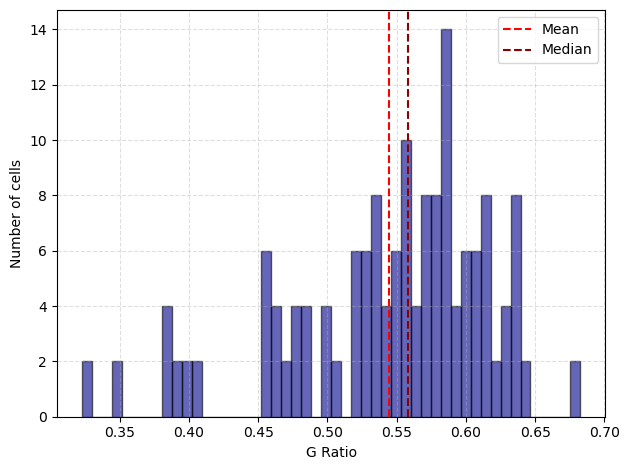

In [10]:
# Plot the histogram of g ratios
plt.hist(measurements_all['gratio'],bins=50, edgecolor='black', color='darkblue', alpha=0.6)

# Customize plot elements
plt.ylabel('Number of cells')
plt.xlabel('G Ratio')
plt.grid(True, linestyle='--', alpha=0.4, which='both')
# plt.xticks(np.arange(0, 1, 5))
# plt.yticks(np.arange(0, 21, 2))

# Add additional plot elements
plt.axvline(measurements_all['gratio'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(measurements_all['gratio'].median(), color='darkred', linestyle='--', label='Median')
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(path_results + "SWM_Sample_results_g_ratio.png",dpi=500)
plt.show()

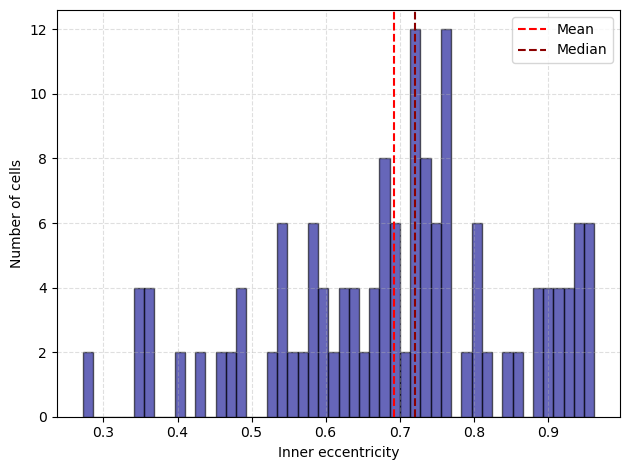

In [11]:
# Plot the histogram of eccentricity
plt.hist(measurements_all['inner_eccentricity'],bins=50, edgecolor='black', color='darkblue', alpha=0.6)

# Customize plot elements
plt.ylabel('Number of cells')
plt.xlabel('Inner eccentricity')
plt.grid(True, linestyle='--', alpha=0.4, which='both')
# plt.xticks(np.arange(0, 1, 5))
# plt.yticks(np.arange(0, 21, 2))

# Add additional plot elements
plt.axvline(measurements_all['inner_eccentricity'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(measurements_all['inner_eccentricity'].median(), color='darkred', linestyle='--', label='Median')
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(path_results + "SWM_Sample_results_eccentricity.png",dpi=500)
plt.show()

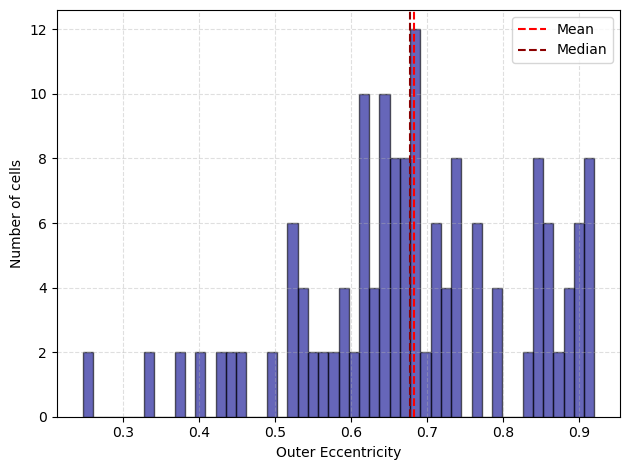

In [12]:
# Plot the histogram of g ratios
plt.hist(measurements_all['outer_eccentricity'],bins=50, edgecolor='black', color='darkblue', alpha=0.6)

# Customize plot elements
plt.ylabel('Number of cells')
plt.xlabel('Outer Eccentricity')
plt.grid(True, linestyle='--', alpha=0.4, which='both')
# plt.xticks(np.arange(0, 1, 5))
# plt.yticks(np.arange(0, 21, 2))

# Add additional plot elements
plt.axvline(measurements_all['outer_eccentricity'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(measurements_all['outer_eccentricity'].median(), color='darkred', linestyle='--', label='Median')
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(path_results + "SWM_Sample_results_eccentricity.png",dpi=500)
plt.show()

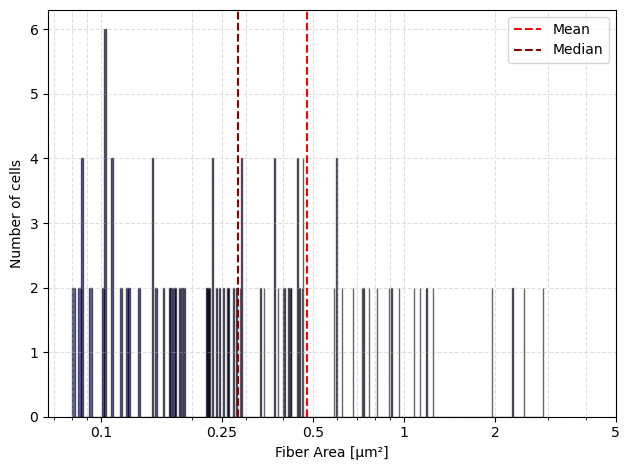

In [13]:
# Plot the histogram of area
plt.hist(measurements_all['inner_area'],bins=1500, edgecolor='black', color='darkblue', alpha=0.6)
# Customize plot elements
plt.ylabel('Number of cells')
plt.xlabel('Fiber Area [µm²]')
plt.grid(True, linestyle='--', alpha=0.4, which='both')
plt.xscale('log')
plt.xticks([0.1,0.25,0.5,1,2,5],[0.1,0.25,0.5,1,2,5])
# plt.yticks(np.arange(0, 21, 2))

# Add additional plot elements
plt.axvline((measurements_all['inner_area']).mean(), color='red', linestyle='--', label='Mean')
plt.axvline((measurements_all['inner_area']).median(), color='darkred', linestyle='--', label='Median')
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(path_results + "SWM_Sample_results_fiber_area.png",dpi=500)
plt.show()

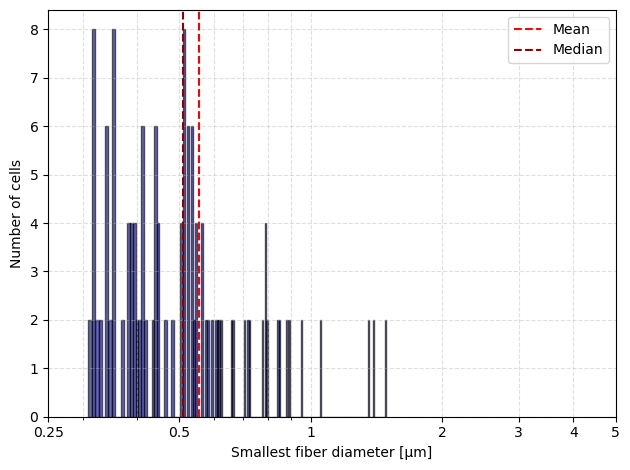

In [14]:
# Plot the histogram of minor axis length
plt.hist((measurements_all['inner_axis_minor_length']), bins=200, edgecolor='black', color='darkblue', alpha=0.6)
# Customize plot elements
plt.ylabel('Number of cells')
plt.xlabel('Smallest fiber diameter [µm]')
plt.grid(True, linestyle='--', alpha=0.4, which='both')
plt.xscale('log')  # Set logarithmic scale on the x-axis
plt.xticks([0.25,0.5,1,2,3,4,5],[0.25,0.5,1,2,3,4,5])  # Set the x-axis tick positions and labels

# Add additional plot elements
plt.axvline((measurements_all['inner_axis_minor_length']).mean(), color='red', linestyle='--', label='Mean')
plt.axvline((measurements_all['inner_axis_minor_length']).median(), color='darkred', linestyle='--', label='Median')
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(path_results + "SWM_Sample_results_fiber_diameter.png", dpi=500)
plt.show()


In [15]:
# plot a polar scatterplot. In this scatterplot, direction (theta) is determined by orientation, 
# displacement (r) is determined by eccentricity
# color is determined by the g ratio, but can be switched to e.g. outer area (commented out line)

fig = px.scatter_polar(measurements_all, 
                    r="eccentricity_mean", 
                    theta="orientation_mean_deg", 
                    # color=measurements_all["gratio"],
                    color=measurements_all["inner_axis_minor_length"],
                    template="plotly_dark",
                    range_color=(0,3),
                    range_theta=(0,180),
                    range_r=(0,1),
                    title="Orientation (radial axis), Eccentricity (angular displacement), fiber diameter (color)")
fig.update_layout(width=1200,height=600)
fig.update_traces(marker=dict(size=4))
fig.update_traces(marker=dict(opacity=1))
fig.update_coloraxes(colorbar_title="Fiber diameter (minor)")
# pio.write_image(fig, path_results + "_Orientation_vs_area_filtered.png")
fig.show()

In [16]:
fig = px.scatter_polar(measurements_all, 
                    r="eccentricity_mean", 
                    theta="orientation_mean_deg", 
                    color=measurements_all["gratio"],
                    template="plotly_dark",
                    range_theta=(0, 180),
                    range_r=(0, 1),
                    title="Orientation (radial axis), Eccentricity (angular displacement), gratio (color)")

fig.data[0].update(mode='markers', marker=dict(size=4))
fig.update_layout(width=1200,height=600)
# pio.write_image(fig, path_results + "_Orientation_vs_gratio.png")
fig.show()


In [17]:
scatter_3d = px.scatter_3d(measurements_all, 
                       x="gratio", 
                       y=z_score_dataframe(measurements_all["eccentricity_mean"] * ((measurements_all["inner_orientation"]+measurements_all["outer_orientation"])/2)), 
                       z=measurements_all["inner_axis_minor_length"], 
                       color=measurements_all["inner_area"],
                       template="ggplot2",
                     #   template="presentation",
                       title="gratio, eccentricity * orientation, inner_minor_axis_length")

scatter_3d.update_traces(marker=dict(size=2))
scatter_3d.update_layout(scene=dict(zaxis=dict(type="log", title="fiber diameter [µm]"),
                                    yaxis=dict(title="orientation * eccentricity"),
                                    xaxis=dict(title="g ratio")),
                                    # bgcolor='rgb(200, 200, 205)'),  # Change the background color of the 3D scene to grey
                        width=1200,  # Adjust the width to your desired value
                        height=1200,  # Adjust the height to your desired value
                        )

scatter_3d.update_coloraxes(cmin=0, cmax=8.7)
scatter_3d.update_coloraxes(colorbar=dict(title="Area [µm²]"))

# Save and display the 3D plot
# pio.write_image(scatter_3d, path_results + "_3D_gratio_orientation_inneraxis.png")
scatter_3d.show()